# Object detection in laser-wakefield acceleration simulations

*Mathieu Lobet, Hiba Taher, Martial Mancip, Merieme BOURENANE, (Maison de la Simulation, Saclay), Francesco Massimo (LPGP, Univ. Paris-Saclay), François Caud, Thomas Moreau (DATAIA, Univ. Paris-Saclay)*

<div>
<table style="width:100%; background-color:transparent;">
  <tr style="background-color:transparent;">
    <td align="left"; style="background-color:transparent; width: 40%;">
        <a href="https://dataia.eu">
            <img src="https://github.com/ramp-kits/lwfa/raw/main/img/DATAIA-h.png" width="450px"/>
        </a>
    </td>
    <td align="right"; style="background-color:transparent; width: 40%;">
        <a href="https://mdls.fr/">
            <img src="https://github.com/ramp-kits/lwfa/raw/main/img/cropped-mdls_logo_texte-1024x421-1.png" width="300px"/>
        </a>
    </td>
  </tr>
 </table>
</div>


## Introduction

Laser-matter interaction is a branch of fundamental physics that explores how the matter reacts when irradiated by one or several intense lasers. High-intensity laser focus a relatively small amount of energy in a short duration ($10^{-14}$ seconds) and a small focal spot (around tens of micrometers.) enabling intensities ranging from $10^{18}$ W/cm^2 to $10^{22}$ W/cm^2 for the most powerful ones. With such an intensity, most materials (from gas to solids) undergo strong ionization forming a local plasma of very interesting properties for many scientific applications. An interesting scenario studied experimentally and numerically in many laser facilities and labs in France (like the [LLR laboratory](https://llr.in2p3.fr/) and the LULI laboratory at Polytechnique, the LPGP lab at Paris-Saclay, the [CELIA lab](https://celia-bordeaux.cnrs.fr/) at Bordeaux or the [Apollon Laser Facililty](https://apollonlaserfacility.cnrs.fr/) at L'Orme des Merisiers) consists on focusing an intense laser in a tailored gas jet as illustrated in the figure below:

<!-- <div>
<img src="./img/laser_wakefield.png" width="800px">
</div> -->

| ![patterns.png](https://github.com/ramp-kits/lwfa/raw/main/img/laser_wakefield.png) |
|:--:|
|<b>Figure 1 - Illustration of the laser wakefield acceleration scenario</b>|

In such a scenario, a laser is sent in a gas jet (for instance hydrogen, helium and more). As it travels in the gas, it ionizes the atoms and creates a plasma in its wake. It creates as well a wakefield like a boat on the water. The wakefield can have different forms but when it reaches the nonlinear regime, it can be composed of cavities with accelerating properties. Free electrons that compose the back skin of the plasma cavities can be injected and trapped inside. They are then accelerated to relativistic energies in a very short distance (few millimeters) and in a very short time (few femtoseconds). Acceleration comes from the existence of strong electric field in the propagation direction at the rear of the cavity. This acceleration mechanism is called laser wakefield acceleration (LWFA) and is a very promising technique to build compact electron accelerators. The accelerated electrons can be used to produce X-rays, to study matter under extreme conditions or to produce secondary particles like positrons. 

[Smilei](https://smileipic.github.io/Smilei/) is a scientific applications jointly developed by Maison de la Simulation, the LULI, the LLR and the LPGP laboratory that simulates the interaction of an intense laser with a plasma. It is used to perform numerical experiments of LWFA scenarios. With the constant increase of computational power, physicist can now perform parametric simulation studies that consist on launching a large number (hundreds to thousands) of 3D simulations with different parameters to explore the influence of these parameters on the physics and optimize the experimental conditions.

Parametric studies generate a large amount of data that can be difficult to analyze by hand. In this context, the development of machine learning algorithms to analyze the data and extract relevant information is of great interest. In this challenge, we propose to develop a machine learning algorithm to detect the presence of different objects in the simulation data.

The following video is a visualization of a  3D simulations using the Smilei PIC code of the laser wakefield acceleration regime.

In [1]:
%%HTML
<video width="1200" controls>
  <source src="https://mdls.fr/wp-content/uploads/2022/04/LWFA_video_Paraview.mp4" type="video/mp4">
</video>

## From simulation parameters to data

In this section, we present the experimental setup. 
The study that we will present is inspired from the following article: [Drobniak, P., et al. "Random scan optimization of a laser-plasma electron injector based on fast particle-in-cell simulations." Physical Review Accelerators and Beams (2023)](https://journals.aps.org/prab/pdf/10.1103/PhysRevAccelBeams.26.091302).
This is mostly to give you the physical background of this study. But to realize the challenge, no need to master the details. The data that we will use for this challenge comes from 500 simulations based on the same initial experimental setup with 4 varying parameters. We call it a parametric study. The experimental setup is schematically described in the following figure:

<!-- <div>
<img src="./img/lwfa_parameters.png" width="400px">
</div> -->

| ![patterns.png](https://github.com/ramp-kits/lwfa/raw/main/img/lwfa_parameters.png) |
|:--:|
|<b>Figure 2 - Illustration of the experimental setup</b>|

The laser will cross 2 gas chambers:
- A first compartment composed of a mixture of Hydrogen and Nitrogen. Nitrogen is used as a reserve of electrons to be injected, taken from levels 6 and 7 of nitrogen by tunnel ionization.
- A second compartment only composed of Hydrogen.

The varying parameters are the following:

- `p`: pressure of the gas in the first compartment. The pressure is drawn from a uniform distribution between 10. and 100. mbar.
- `C_N2`: percentage of nitrogen in the first compartment.
- `x_off`: focusing distance of the laser in the first chamber.
- `a_0`: the laser amplitude


Although the simulations are 3D, we analyze slices for simplicity. This is possible because the simulations are axisymmetric in the longitudinal direction (so-called `x` direction).
Each simulation has a total of 64800 iterations. Diagnostics are made every 1200 iterations meaning that each simulation has 54 diagnostics iterations.
We theoretically have a total of 27000 diagnostics but only 800 are labelled.
Diagnostics are composed of different physical parameters stored in 2D Numpy arrays of size `798` x `640`. 
We do not use all the available physical parameters but only kept the following:
- **Diag 0**: The charge density of the electrons from the ionized hydrogen
- **Diag 1**: The charge density of the electrons from the ionized nitrogen

Moreover, the data is normalized so that the colormaps can be constant for all the simulations. We use the following normalization:
- **Diag 0**: normalized by the background plasma density.
- **Diag 1**: normalized by the maximum value at each iteration.

In the following, we will present step by step a simulation using images plotted thanks to Matplotlib. 
We add an extra physical parameter that will not be contained in the dataset that corresponds to the laser envelope intensity. 
It helps to understand where the laser is located.
Numerically, we do not simulate the whole gas chamber because it would be too computationally expensive. Instead, we use a moving window that follows the laser (like a camera doing a tracking shot). By this way, we only simulate the region of interest with the laser being on the right side and the plasma wakefield from the center to the left.

<!-- <div>
<img src="./img/S000_003600.png" width="800px">
</div> -->

| ![patterns.png](https://github.com/ramp-kits/lwfa/raw/main/img/S000_003600.png) |
|:--:|
|**STEP 1**: The laser has entered the first gas chamber. It starts to create a weakly nonlinear wakefield. There is for the moment no electrons from nitrogen ionization. At this stage, we want to detect the different wakefield cavities.|

<!-- <div>
<img src="./img/S000_009600.png" width="800px">
</div> -->

| ![patterns.png](https://github.com/ramp-kits/lwfa/raw/main/img/S000_009600.png) |
|:--:|
|**STEP 2**: The wakefield is more and more intense as the laser gets more and more focused. With the increase of the laser intensity, electrons from nitrogen ionization start to appear. An electron beam starts to form in the first wakefield cavity. At this stage, we still want to detect the wakefield cavity and the electron beam.|

| ![patterns.png](https://github.com/ramp-kits/lwfa/raw/main/img/S000_013200.png) |
|:--:|
|**STEP 3**: The electron beam from ionized nitrogen becomes so intense that it starts to create another wakefield. On subfigure a), there is a superimposition of both the laser-driven wakefield and beam-driven wakefield. |

| ![patterns.png](https://github.com/ramp-kits/lwfa/raw/main/img/S000_024000.png) |
|:--:|
|**STEP 4**: On subfigure b),  There is a clear and dense electron beam. On subfigure a), we can not distinguish anymore the laser-driven and the beam-driven cavities except for the first one. At this stage, we still want to detect the first cavity. Then, for simplicity the following cavities are just considered as beam-driven. |

| ![patterns.png](https://github.com/ramp-kits/lwfa/raw/main/img/S000_048000.png) |
|:--:|
|**STEP 5**: Later, the laser enters the second gas chamber. No more electrons from ionized nitrogen are created. However, the existing beam still gain energy from the laser-driven wakefield. At some point, some electrons from ionized hydrogen can be also injected in the combination of the laser and beam-driven wakefield. In this simulation, it corresponds to the small beam in subfigure a). In some configurations, this second beam does not appear and in other it can be bigger and denser.  At this stage, we add a new class to detect this electron beam from ionized hydrogen (background plasma). |

| ![patterns.png](https://github.com/ramp-kits/lwfa/raw/main/img/S000_060000.png) |
|:--:|
|**STEP 6**: Near the end of the simulation, the laser is unfocused and deteriorated due to the interaction with the plasma. Therefore, the wakefield is no more driven by the laser and entirely driven by the strong electron beam on subfigure b). We are in a new regime called beam-driven wakefield acceleration. At this stage, we still want to detect the beam-driven wakefield. |

To summarize, we want to detect the following objects:
- **Class 0**: The electron beam from ionized nitrogen
- **Class 1**: The laser-driven wakefield cavity
- **Class 2**: The beam-driven wakefield cavity
- **Class 3**: The electron beam from ionized hydrogen (background plasma)

In the next section, we will present the data and how to process them.

## Requirements

In [1]:
import pickle
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.animation as animation
import glob

## Data exploration

The dataset is a subset of simulation data extracted from the 500 simulations performed with Smilei. It is composed of **1568 labelled iterations** more or less randomly chosen. We split the dataset into training and testing sets while ensuring that data from the same simulation is kept together in one split (to avoid data leakage) and end up with **1256 labelled iterations** in the public dataset (1004 in the public train set and 252 in the public test set) and **312 labelled iterations** kept in the private test set. A single iteration is composed of 2 diagnostics: the electron density from hydrogen (also called background electrons) and the electron from the ionized Nitrogen. Each diagnostic is represented by an array of float. This array is stored in a pickle file with metadata. For each array we can plot an images as the ones presented in the previous section.

The structure of the dataset is as follows:
- `classes.txt` : a file containing the classes of the objects to detect
- `train`: a folder containing the raw data (pickle format) and labels for the objects to detect (txt format) for all simulations, iterations and diagnostics of the training set. For simulation `0`, we also kept diag 2 raw data (laser envelope intensity) in order to understand where the laser is located.
- `test`: a folder containing the raw data (pickle format) and labels for the objects to detect (txt format) for all simulations, iterations and diagnostics of the test set

File names always follow the same pattern: `S{:03d}_{:06d}_{:02d}.format(simulation_index, iteration, diag)` where:
- `simulation_index` is the index of the simulation
- `iteration` is the index of the iteration
- `diag` is the index of the diagnostic (0 for the electron density from ionized hydrogen and 1 for the electron density from ionized Nitrogen)

Raws have the extension `.pkl`. For instance `S000_0052600_01.pkl` represents the raw data for the simulation 0, iteration `52600` and diagnostic `1`. Pickle files contain a dictionary with the following keys:

```python
    pickle_data = {
        "x_label" : "x",
        "x_min" : x_min,
        "x_max" : x_max,
        "x_size" : x_size,
        "y_label" : "y",
        "y_min" : y_min,
        "y_max" : y_max,
        "y_size" : y_size,
        "data_label" : Params["diag_label"][idiag],
        "data" : timestep_data
    }
```

### How to read the data

Let's load the data and explore it.
First, download the data and set the path:


In [2]:
# Uncomment the following line to download data:
!python download_data.py

Checking the data URL...Ok.
100%|████████████████████████████████████| 369M/369M [00:16<00:00, 22.1Mbytes/s]
Extracting now...Ok.
Removing the archive...Ok.
Checking the data...Ok.


In [2]:
dataset_path = "./data/"

Then, set a simulation id and an iteration:

In [3]:
simulation_number = 0
iteration = 50400

The following piece of code will load the raw data and the labels for the selected simulation and iteration:

In [4]:

simulation_folder = dataset_path + "/train/".format(simulation_number)

# Open both diags
with open(simulation_folder + "S{:03d}_{:06d}_00.pkl".format(simulation_number, iteration), 'rb') as f:
    diag_0 = pickle.load(f)
with open(simulation_folder + "S{:03d}_{:06d}_01.pkl".format(simulation_number, iteration), 'rb') as f:
    diag_1 = pickle.load(f)
with open(simulation_folder + "S{:03d}_{:06d}_02.pkl".format(simulation_number, iteration), 'rb') as f:
    diag_2 = pickle.load(f)

print(" - xlabel: {}, xmin: {}, xmax: {}, xsize: {}".format(diag_0["x_label"], diag_0["x_min"], diag_0["x_max"], diag_0["x_size"]))
print(" - ylabel: {}, ymin: {}, ymax: {}, ysize: {}".format(diag_0["y_label"], diag_0["y_min"], diag_0["y_max"], diag_0["y_size"]))

print(" Diag 0 labels: {}".format(diag_0["data_label"]))
print(" Diag 1 labels: {}".format(diag_1["data_label"]))
print(" Diag 2 labels: {}".format(diag_2["data_label"]))

x_axis = np.linspace(diag_0["x_min"], diag_0["x_max"], diag_0["x_size"])
y_axis = np.linspace(diag_0["y_min"], diag_0["y_max"], diag_0["y_size"])


 - xlabel: x, xmin: 0.0, xmax: 502.6548245743669, xsize: 640
 - ylabel: y, ymin: -501.0494724824822, ymax: 501.0494724824823, ysize: 798
 Diag 0 labels: Hydrogen electron density
 Diag 1 labels: Nitrogen electron density
 Diag 2 labels: Laser envelope intensity



### How to read the labels

The file `classes.txt` contain all the classes and associated names. The following code will load the classes:

In [5]:
with open(dataset_path + "/classes.txt", 'r') as f:
    lines = f.readlines()

for iline, line in enumerate(lines):
    print(" {}: {}".format(iline, line))

 0: beam_from_ionisation

 1: laser_driven_wakefield

 2: beam_driven_wakefield

 3: beam_from_background



Each diag is associated with a label file. The label file is a txt file where each line is a detected object. A line contains the class and the relative box coordinates (normalized between 0 and 1) with the following format: `class_id x_center y_center width height`.

In [6]:
# Open the txt file

with open(dataset_path + "train/S{:03d}_{:06d}_00.txt".format(simulation_number, iteration), 'r') as f:
    diag0_labels = f.readlines()
with open(dataset_path + "train/S{:03d}_{:06d}_01.txt".format(simulation_number, iteration), 'r') as f:
    diag1_labels = f.readlines()

print(" Objects for diags 0:")
for i in range(len(diag0_labels)):
    print(" - {}".format(diag0_labels[i]))
print(" Objects for diags 1:")
for i in range(len(diag1_labels)):
    print(" - {}".format(diag1_labels[i]))

 Objects for diags 0:
 - 3 0.101434 0.500926 0.010753 0.014811

 - 2 0.233333 0.499074 0.449462 0.218465

 Objects for diags 1:
 - 0 0.347670 0.500000 0.199283 0.101827

 - 0 0.136559 0.500926 0.082437 0.144409



Here for example, we verify that all objects in diag 1 images (from the training set) are from class 0.

In [7]:
# Get all labels from *_01.txt files and count classes
diag1_labels_all = []
for file in glob.glob(dataset_path + "train/*_01.txt"):
    with open(file, 'r') as f:
        labels = f.readlines()
        diag1_labels_all.extend(labels)

# Count occurrences of each class
class_counts = {}
for label in diag1_labels_all:
    class_id = int(label.split()[0])
    class_counts[class_id] = class_counts.get(class_id, 0) + 1

print("Class value counts:")
for class_id, count in sorted(class_counts.items()):
    print(f"Class {class_id}: {count}")


Class value counts:
Class 0: 1123


If we do the same for diag 0:

In [8]:
# Get all labels from *_00.txt files and count classes
diag0_labels_all = []
for file in glob.glob(dataset_path + "train/*_00.txt"):
    with open(file, 'r') as f:
        labels = f.readlines()
        diag0_labels_all.extend(labels)

# Count occurrences of each class
class_counts = {}
for label in diag0_labels_all:
    class_id = int(label.split()[0])
    class_counts[class_id] = class_counts.get(class_id, 0) + 1

print("Class value counts:")
for class_id, count in sorted(class_counts.items()):
    print(f"Class {class_id}: {count}")

Class value counts:
Class 1: 718
Class 2: 787
Class 3: 374


We can define a function to easily plot the box on the colormaps.
Here, the colors respectively refer to the following classes:
- red: electron beam from ionized Nitrogen
- 'C1' (green): beam driven wakefield
- 'C2' (orange): laser driven wakefield
- 'C4' (purple): electron beam from ionized Hydrogen

In [9]:
def plot_label_box(ax, file_path, xlim, ylim):

    # colors for the labels
    class_colors = ['red', 'C1', 'C2', 'C4']

    with open(file_path, 'rb') as f:
        lines = f.readlines()
        for line in lines:
            class_id = int(line.split()[0])
            xcn = float(line.split()[1])
            ycn = float(line.split()[2])
            wn = float(line.split()[3])
            hn = float(line.split()[4])

            xmin = xlim[0] + (xlim[1]-xlim[0]) * (xcn - wn*0.5)
            xmax = xlim[0] + (xlim[1]-xlim[0]) * (xcn + wn*0.5)
            ymin = ylim[0] + (ylim[1]-ylim[0]) * (ycn - hn*0.5)
            ymax = ylim[0] + (ylim[1]-ylim[0]) * (ycn + hn*0.5)

            width = xmax - xmin
            height = ymax - ymin

            ax.add_patch(plt.Rectangle((xmin, ymin), width, height, fill=False, edgecolor=class_colors[class_id], linewidth=2))

### Plot the data

Now, we can use Matplotlib to plot the data for the selected simulation at the selected iteration:

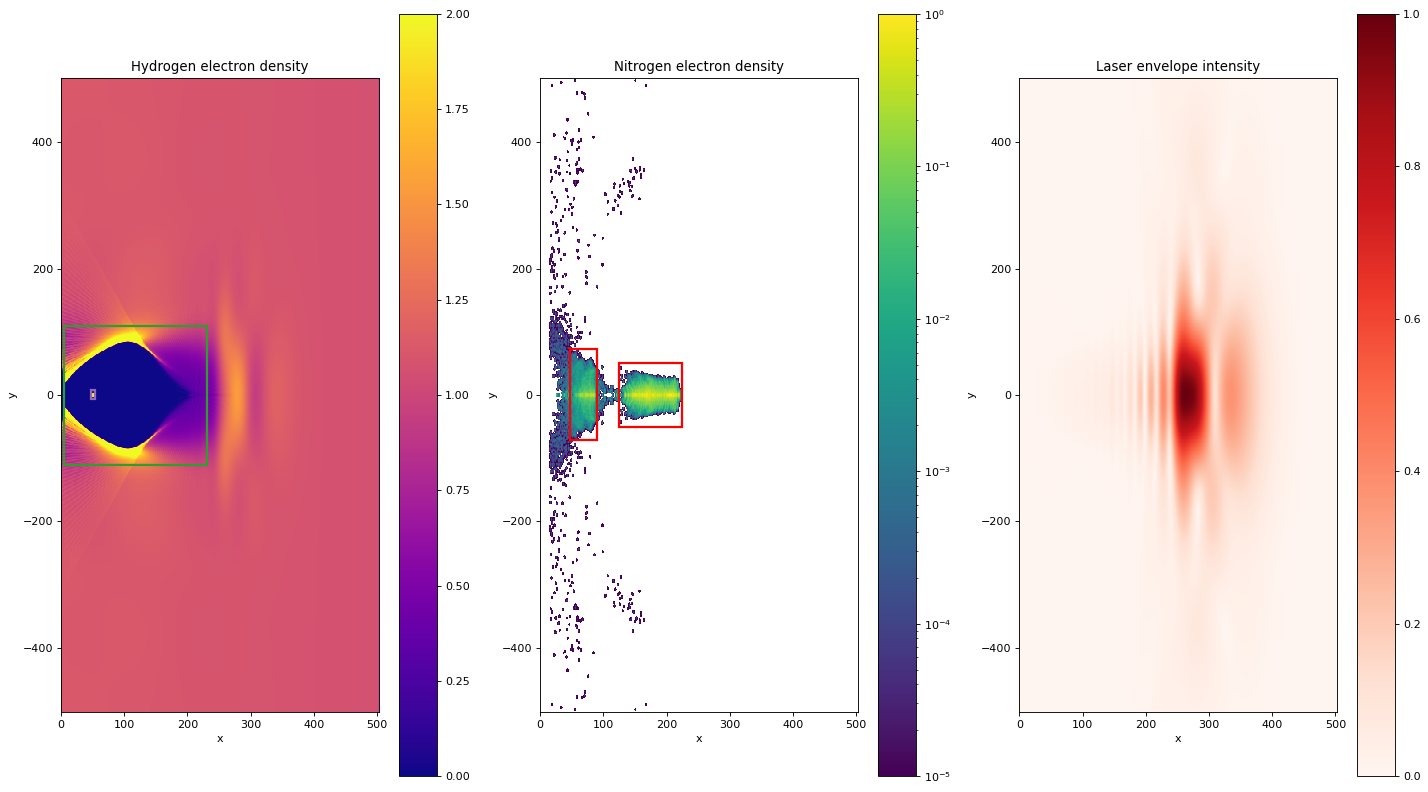

In [10]:
fig0 = plt.figure(figsize=(18, 10), dpi=80)
gs = plt.GridSpec(2, 3)
ax0 = plt.subplot(gs[:,0])
ax1 = plt.subplot(gs[:,1])
ax2 = plt.subplot(gs[:,2])

# _________________________________________________________
# First diag: 
im0 = ax0.pcolormesh(x_axis,y_axis,diag_0['data'],
                    cmap=plt.get_cmap("plasma"),
                    #norm=norm,
                    shading='auto')

im0.set_clim(vmin=0, vmax=2)

ax0.set_xlabel(diag_0["x_label"])
ax0.set_ylabel(diag_0["y_label"])
ax0.set_aspect(1)
ax0.set_title(diag_0["data_label"])
cb0 = plt.colorbar(im0)

# Add the object boxes
xlim = ax0.get_xlim()
ylim = ax0.get_ylim()
plot_label_box(ax0, dataset_path + "train/S{:03d}_{:06d}_00.txt".format(simulation_number, iteration), xlim, ylim)


# _________________________________________________________
# Second diag: charge density of electrons from Nitrogen

im1 = ax1.pcolormesh(x_axis,y_axis,diag_1['data'],
                    cmap=plt.get_cmap("viridis"),
                    #norm=norm,
                    shading='auto')

im1.set_clim(vmin=1e-5, vmax=1)

ax1.set_xlabel(diag_1["x_label"])
ax1.set_ylabel(diag_1["y_label"])
ax1.set_aspect(1)

norm = colors.LogNorm(vmin=1e-5, vmax=1)
im1.set_norm(norm)
ax1.set_title(diag_1["data_label"])
cb1 = plt.colorbar(im1)

# Add the object boxes
xlim = ax1.get_xlim()
ylim = ax1.get_ylim()
plot_label_box(ax1, dataset_path + "train/S{:03d}_{:06d}_01.txt".format(simulation_number, iteration), xlim, ylim)

# _________________________________________________________
# Third diag: laser envelope

im2 = ax2.pcolormesh(x_axis,y_axis,diag_2['data'],
                    cmap=plt.get_cmap("Reds"),
                    #norm=norm,
                    shading='auto')

im2.set_clim(vmin=0, vmax=1)

ax2.set_xlabel(diag_2["x_label"])
ax2.set_ylabel(diag_2["y_label"])
ax2.set_aspect(1)

ax2.set_title("Laser envelope intensity")
cb2 = plt.colorbar(im2)

plt.tight_layout()

plt.show()

Following the same procedure we can as well create an animation gathering all time steps for a given simulation. Since we did not label all iterations of each simulation, some simulations may have very few images or not any. The simulation `0` is completely labelled.

In [2]:
#plt.rcParams["animation.html"] = "jshtml"

# Get all the files for the selected simulation

diags = glob.glob(dataset_path + "/train/S{:03d}_*.pkl".format(simulation_number))

# removed file `*_01.pkl` and `*_02.pkl`
diags = [d for d in diags if (not d.endswith("_01.pkl") and not d.endswith("_02.pkl"))]

# only keep the file name and remove extension
diags = [d.split("/")[-1].replace("_00.pkl", "") for d in diags]

# Sort the files by iteration number
diags.sort()

print("Number of available iterations: {}".format(len(diags)))

def animate(i):

    ax0.cla()
    ax1.cla()
    ax2.cla()

    with open(dataset_path + "/train/" + diags[i] + "_00.pkl", 'rb') as f:
        diag_0 = pickle.load(f)
    with open(dataset_path + "/train/" + diags[i] + "_01.pkl", 'rb') as f:
        diag_1 = pickle.load(f)
    with open(dataset_path + "/train/" + diags[i] + "_02.pkl", 'rb') as f:
        diag_2 = pickle.load(f)

    x_axis = np.linspace(diag_0["x_min"], diag_0["x_max"], diag_0["x_size"])
    y_axis = np.linspace(diag_0["y_min"], diag_0["y_max"], diag_0["y_size"])

    # _________________________________________________________
    # First diag
    
    im0 = ax0.pcolormesh(x_axis,y_axis,diag_0['data'],
                        cmap=plt.get_cmap("plasma"),
                        #norm=norm,
                        shading='auto')

    im0.set_clim(vmin=0, vmax=2)
    ax0.set_xlabel(diag_0["x_label"])
    ax0.set_ylabel(diag_0["y_label"])
    ax0.set_aspect(1)
    ax0.set_title(diag_0["data_label"])

    # Add the object boxes
    xlim = ax0.get_xlim()
    ylim = ax0.get_ylim()
    plot_label_box(ax0, dataset_path + "train/" + diags[i] + "_00.txt".format(simulation_number, iteration), xlim, ylim)

    # _________________________________________________________
    # Second diag:
    
    im1 = ax1.pcolormesh(x_axis,y_axis,diag_1['data'],
                        cmap=plt.get_cmap("viridis"),
                        #norm=norm,
                        shading='auto')
    
    im1.set_clim(vmin=1e-5, vmax=1)
    ax1.set_xlabel(diag_1["x_label"])
    ax1.set_ylabel(diag_1["y_label"])
    ax1.set_aspect(1)
    
    norm = colors.LogNorm(vmin=1e-5, vmax=1)
    im1.set_norm(norm)
    
    ax1.set_title(diag_1["data_label"])
    
    # Add the object boxes
    xlim = ax0.get_xlim()
    ylim = ax0.get_ylim()
    plot_label_box(ax1, dataset_path + "train/" + diags[i] + "_01.txt".format(simulation_number, iteration), xlim, ylim)

    # _________________________________________________________
    # Third diag: laser envelope

    im2 = ax2.pcolormesh(x_axis,y_axis,diag_2['data'],
                        cmap=plt.get_cmap("Reds"),
                        #norm=norm,
                        shading='auto')
    
    im2.set_clim(vmin=0, vmax=1)
    ax2.set_xlabel(diag_2["x_label"])
    ax2.set_ylabel(diag_2["y_label"])
    ax2.set_aspect(1)

    ax2.set_title("Laser envelope intensity")

    return im0, im1, im2

fig = plt.figure(figsize=(18, 10), dpi=80)
gs = plt.GridSpec(2, 3)
ax0 = plt.subplot(gs[:,0])
ax1 = plt.subplot(gs[:,1])
ax2 = plt.subplot(gs[:,2])

ani = animation.FuncAnimation(fig, animate, np.arange(0, len(diags)))

from IPython.display import HTML
HTML(ani.to_jshtml())


### Let's load the training data:

In [1]:
# In case you use Google Colab, you need to run the following lines to add the ramp_custom package to the Python path (otherwise, you cannot import problem)

# import sys
# sys.path.append('/content/drive/MyDrive/lwfa/ramp_custom')

In [ ]:
# check the Python path
# print(sys.path)

In [11]:
import problem

X_train, y_train = problem.get_train_data()

print(X_train.shape)
print(y_train.shape)

(1004,)
(1004,)


There are 1004 training examples. For each example, we have a 2x798x640 array (which is the concatenation of the two diagnostics) and a list of annotations, corresponding to the objects present in the image. Each object is a dictionary with the following keys: `bbox` (bounding box coordinates), `class` (class id).

In [12]:
X_train[0]['data'].shape

(2, 798, 640)

In [13]:
y_train

array([list([{'bbox': [0.313978, 0.503703, 0.626523, 0.398052], 'class': 1}]),
       list([{'bbox': [0.38853, 0.502777, 0.530466, 0.411011], 'class': 1}]),
       list([{'bbox': [0.43405, 0.511109, 0.432258, 0.416566], 'class': 1}]),
       ...,
       list([{'bbox': [0.424516, 0.504896, 0.420645, 0.217363], 'class': 1}, {'bbox': [0.234194, 0.500653, 0.465806, 0.181462], 'class': 2}, {'bbox': [0.057265, 0.503117, 0.078051, 0.065888], 'class': 0}, {'bbox': [0.345106, 0.500622, 0.230446, 0.084488], 'class': 0}]),
       list([{'bbox': [0.408387, 0.498695, 0.442581, 0.189295], 'class': 1}, {'bbox': [0.226452, 0.500326, 0.450323, 0.18342], 'class': 2}, {'bbox': [0.344516, 0.499674, 0.229677, 0.07376], 'class': 0}, {'bbox': [0.056774, 0.5, 0.067097, 0.044386], 'class': 0}]),
       list([{'bbox': [0.05871, 0.500326, 0.055484, 0.028068], 'class': 3}, {'bbox': [0.231613, 0.500326, 0.460645, 0.253916], 'class': 2}, {'bbox': [0.138065, 0.499674, 0.010323, 0.015013], 'class': 3}, {'bbox': [0.26

### Distribution of classes in the training set

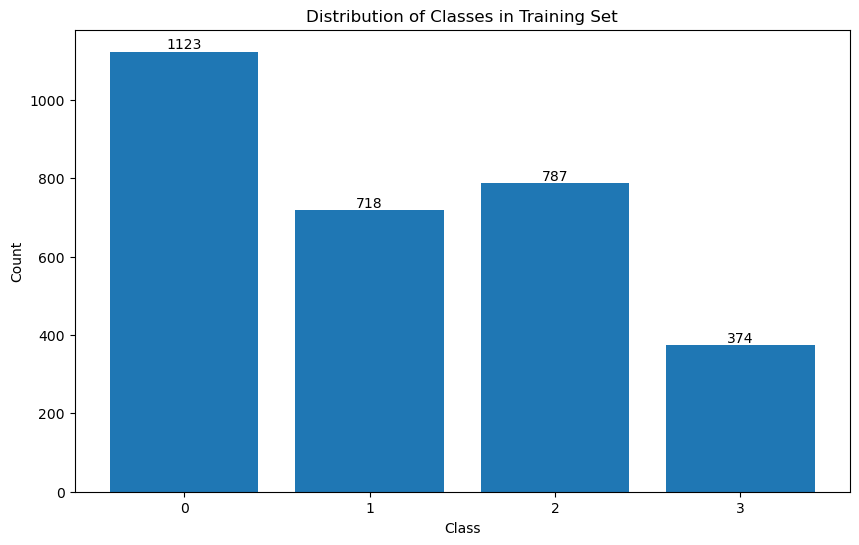

In [14]:
# Get all classes from the annotations
all_classes = []
for img_annotations in y_train:
    for annotation in img_annotations:
        all_classes.append(annotation['class'])

# Convert to numpy array for easier counting
all_classes = np.array(all_classes)

# Count occurrences of each class
unique_classes, counts = np.unique(all_classes, return_counts=True)

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(unique_classes, counts)
plt.title('Distribution of Classes in Training Set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(unique_classes)

# Add count labels on top of each bar
for i, count in enumerate(counts):
    plt.text(unique_classes[i], count, str(count), ha='center', va='bottom')

plt.show()


### Test data

In [15]:
X_test, y_test = problem.get_test_data()

print(X_test.shape)
print(y_test.shape)


(252,)
(252,)


### Distribution of classes in the test set

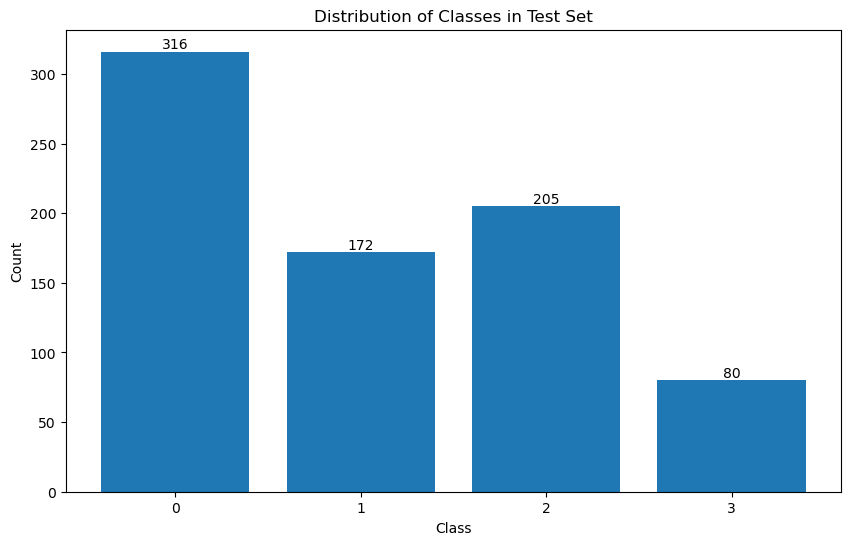

In [16]:
# Get all classes from the annotations
all_classes = []
for img_annotations in y_test:
    for annotation in img_annotations:
        all_classes.append(annotation['class'])

# Convert to numpy array for easier counting
all_classes = np.array(all_classes)

# Count occurrences of each class
unique_classes, counts = np.unique(all_classes, return_counts=True)

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(unique_classes, counts)
plt.title('Distribution of Classes in Test Set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(unique_classes)

# Add count labels on top of each bar
for i, count in enumerate(counts):
    plt.text(unique_classes[i], count, str(count), ha='center', va='bottom')

plt.show()


### Comparison of the class distribution between training and test data

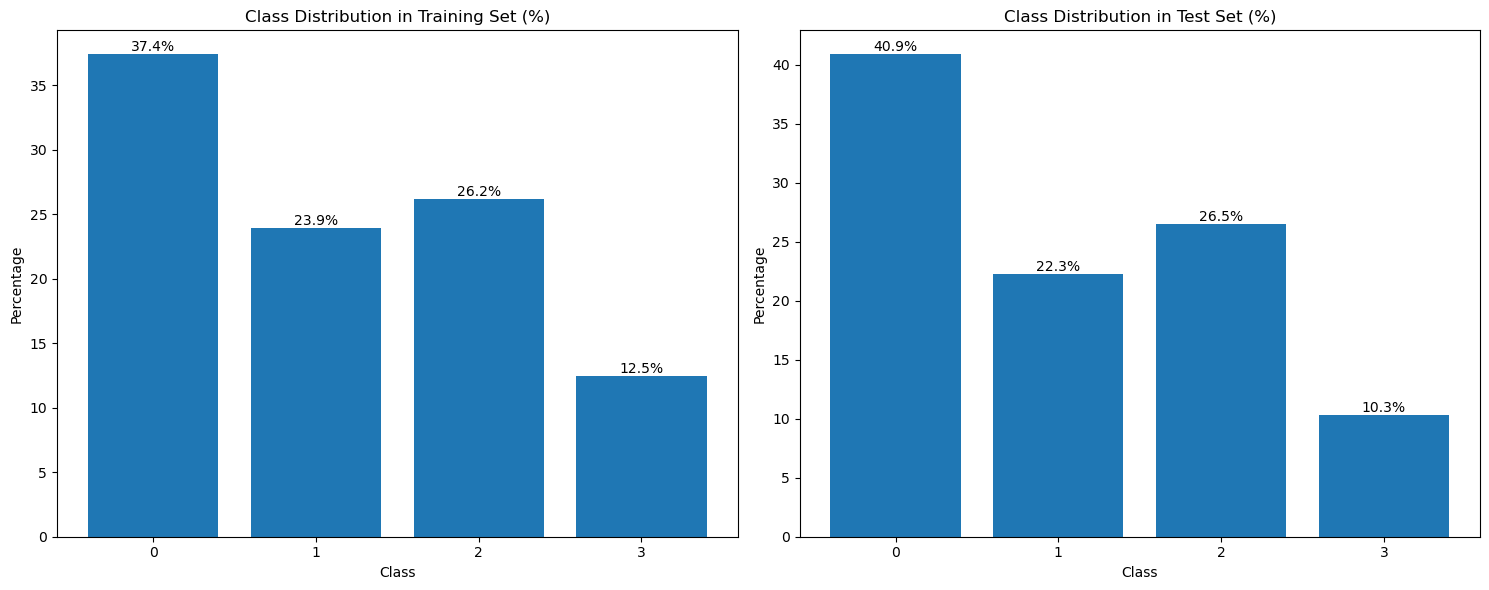

In [17]:
# Get all classes from the annotations for training data
all_classes_train = []
for img_annotations in y_train:
    for annotation in img_annotations:
        all_classes_train.append(annotation['class'])

# Convert to numpy array for easier counting
all_classes_train = np.array(all_classes_train)

# Count occurrences and calculate percentages for training data
unique_classes_train, counts_train = np.unique(all_classes_train, return_counts=True)
percentages_train = counts_train / len(all_classes_train) * 100

# Calculate percentages for test data
percentages_test = counts / len(all_classes) * 100

# Create a figure with two subplots side by side
plt.figure(figsize=(15, 6))

# First subplot for training data
plt.subplot(1, 2, 1)
plt.bar(unique_classes_train, percentages_train)
plt.title('Class Distribution in Training Set (%)')
plt.xlabel('Class')
plt.ylabel('Percentage')
plt.xticks(unique_classes_train)
# Add percentage labels on top of each bar
for i, pct in enumerate(percentages_train):
    plt.text(unique_classes_train[i], pct, f'{pct:.1f}%', ha='center', va='bottom')

# Second subplot for test data
plt.subplot(1, 2, 2)
plt.bar(unique_classes, percentages_test)
plt.title('Class Distribution in Test Set (%)')
plt.xlabel('Class')
plt.ylabel('Percentage')
plt.xticks(unique_classes)
# Add percentage labels on top of each bar
for i, pct in enumerate(percentages_test):
    plt.text(unique_classes[i], pct, f'{pct:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()


### Distribution of box sizes in the training set

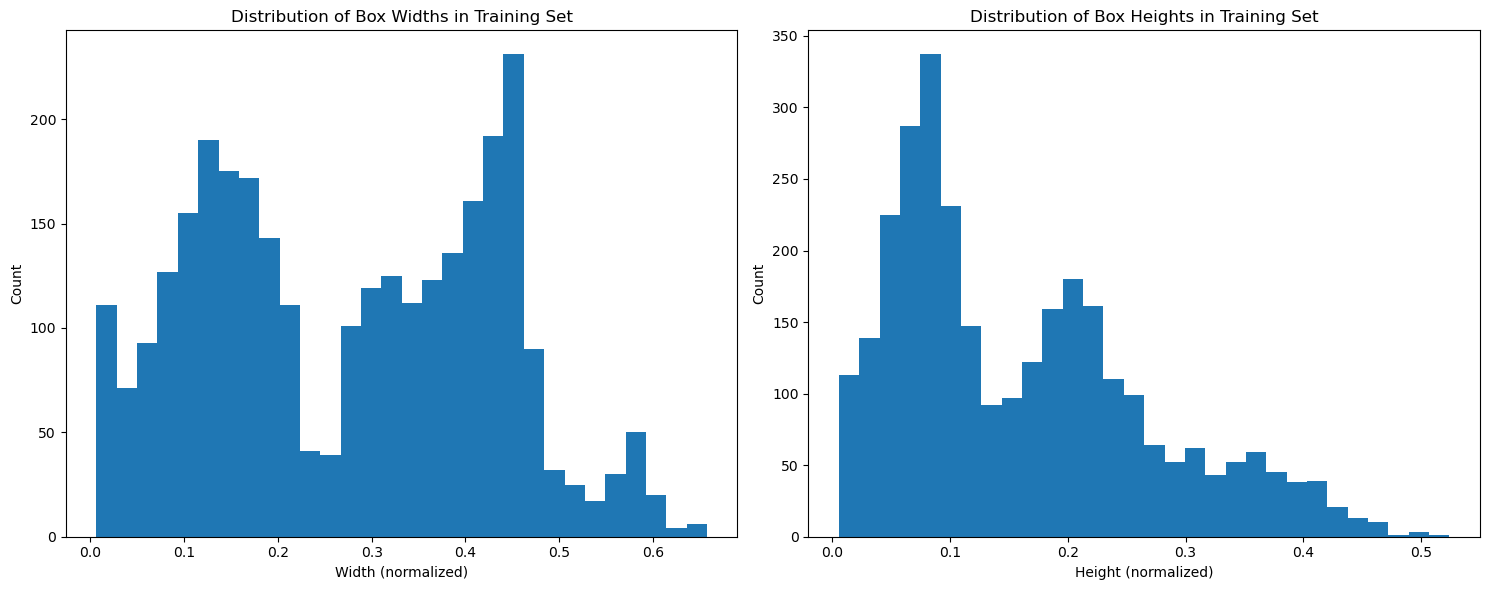


Box size statistics in training set:
Width - Mean: 0.274, Std: 0.155, Min: 0.006, Max: 0.658
Height - Mean: 0.160, Std: 0.108, Min: 0.006, Max: 0.524


In [18]:
# Get all box sizes from the annotations for training data
widths_train = []
heights_train = []
for img_annotations in y_train:
    for annotation in img_annotations:
        bbox = annotation['bbox']
        widths_train.append(bbox[2])  # width is 3rd element
        heights_train.append(bbox[3])  # height is 4th element

# Convert to numpy arrays
widths_train = np.array(widths_train)
heights_train = np.array(heights_train)

# Create a figure with two subplots side by side
plt.figure(figsize=(15, 6))

# First subplot for width distribution
plt.subplot(1, 2, 1)
plt.hist(widths_train, bins=30)
plt.title('Distribution of Box Widths in Training Set')
plt.xlabel('Width (normalized)')
plt.ylabel('Count')

# Second subplot for height distribution  
plt.subplot(1, 2, 2)
plt.hist(heights_train, bins=30)
plt.title('Distribution of Box Heights in Training Set')
plt.xlabel('Height (normalized)') 
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Print some statistics
print("\nBox size statistics in training set:")
print(f"Width - Mean: {widths_train.mean():.3f}, Std: {widths_train.std():.3f}, Min: {widths_train.min():.3f}, Max: {widths_train.max():.3f}")
print(f"Height - Mean: {heights_train.mean():.3f}, Std: {heights_train.std():.3f}, Min: {heights_train.min():.3f}, Max: {heights_train.max():.3f}")


### Distribution of box areas in the training set

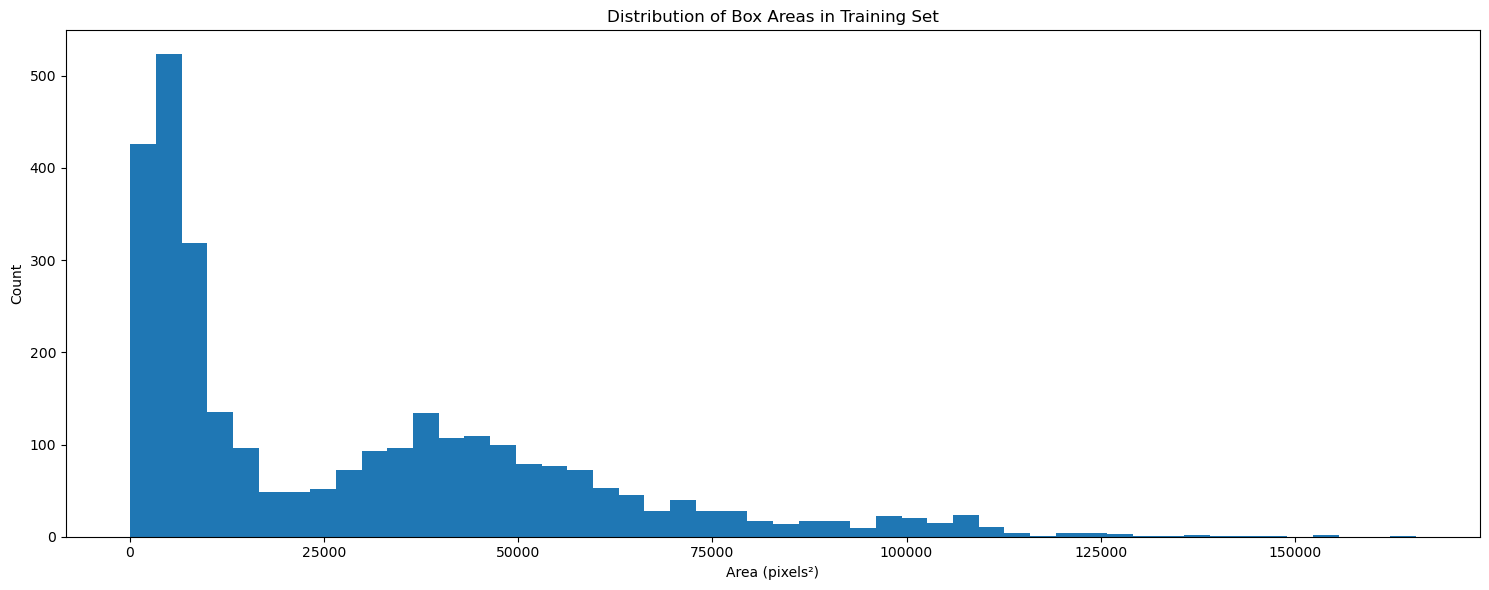


Box area statistics in training set (pixels²):
Area - Mean: 28815.7, Std: 28716.9, Min: 27.1, Max: 165574.1


In [19]:
# Get all box areas in pixels for training data
areas_train_pixels = []
for img_annotations, img in zip(y_train, X_train):
    img_height, img_width = img['data'].shape[1:]
    for annotation in img_annotations:
        bbox = annotation['bbox']
        # Convert normalized coordinates to pixels and calculate area
        width_pixels = bbox[2] * img_width
        height_pixels = bbox[3] * img_height
        area = width_pixels * height_pixels
        areas_train_pixels.append(area)

# Convert to numpy array
areas_train_pixels = np.array(areas_train_pixels)

# Create figure
plt.figure(figsize=(15, 6))

# Plot area distribution
plt.hist(areas_train_pixels, bins=50)
plt.title('Distribution of Box Areas in Training Set')
plt.xlabel('Area (pixels²)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Print statistics
print("\nBox area statistics in training set (pixels²):")
print(f"Area - Mean: {areas_train_pixels.mean():.1f}, Std: {areas_train_pixels.std():.1f}, Min: {areas_train_pixels.min():.1f}, Max: {areas_train_pixels.max():.1f}")


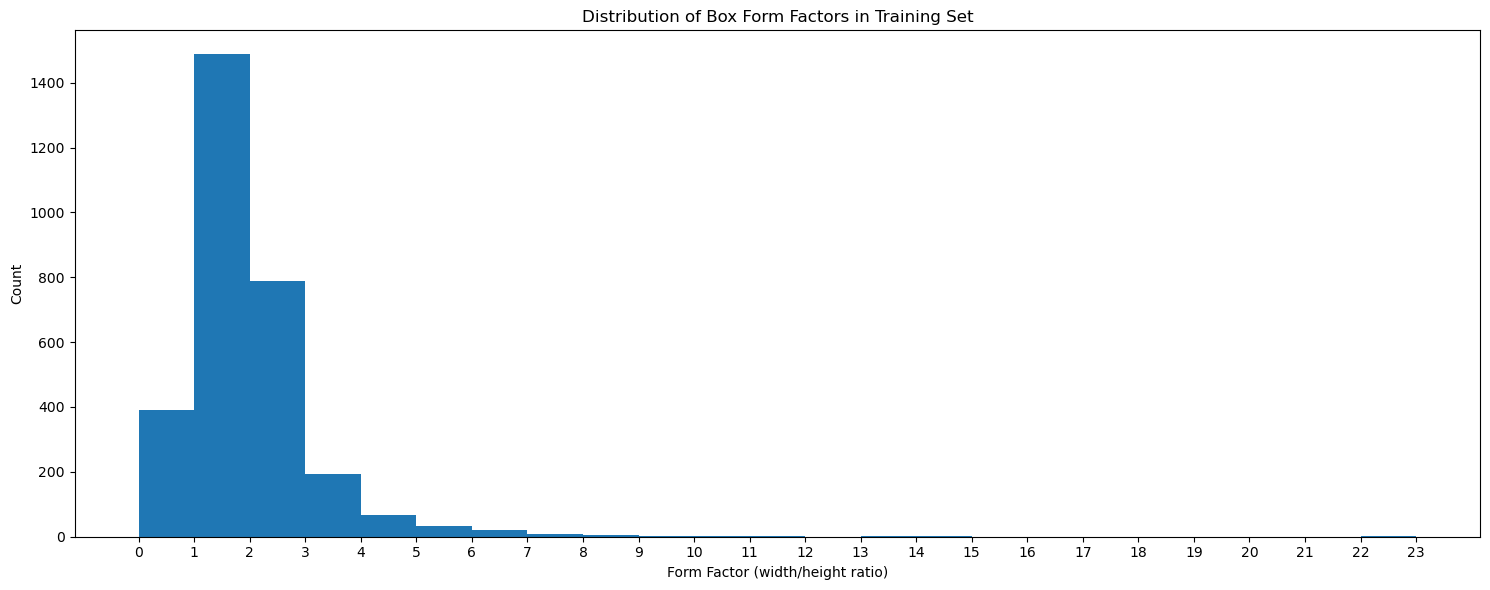


Box form factor statistics in training set:
Form Factor - Mean: 1.994, Std: 1.206, Min: 0.240, Max: 22.829


In [20]:
# Calculate form factors (width/height ratio) for training data
form_factors_train = []
for img_annotations, img in zip(y_train, X_train):
    for annotation in img_annotations:
        bbox = annotation['bbox']
        form_factor = bbox[2] / bbox[3]  # width/height ratio
        form_factors_train.append(form_factor)

# Convert to numpy array
form_factors_train = np.array(form_factors_train)

# Create figure
plt.figure(figsize=(15, 6))

# Plot form factor distribution
# Calculate bin edges with unit spacing
bin_min = np.floor(form_factors_train.min())
bin_max = np.ceil(form_factors_train.max())
bins = np.arange(bin_min, bin_max + 1, 1.0)  # +1 to include the last value

plt.hist(form_factors_train, bins=bins)
plt.title('Distribution of Box Form Factors in Training Set')
plt.xlabel('Form Factor (width/height ratio)')
plt.ylabel('Count')

# Set x-ticks to show every integer
plt.xticks(bins)

plt.tight_layout()
plt.show()

# Print statistics
print("\nBox form factor statistics in training set:")
print(f"Form Factor - Mean: {form_factors_train.mean():.3f}, Std: {form_factors_train.std():.3f}, Min: {form_factors_train.min():.3f}, Max: {form_factors_train.max():.3f}")


## Base model

We will use a Faster R-CNN model from the torchvision library.

In [21]:
# Imports for the model
import torch
from torch import nn
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.transform import GeneralizedRCNNTransform
import torch.optim as optim

In [22]:
# Model
weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn(weights=weights)
# Modify the first conv layer to accept 2 channels instead of 3
model.backbone.body.conv1 = nn.Sequential(
    nn.Conv2d(2, 64, kernel_size=7, stride=2, padding=3, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True)
)
# Create new transform with 2-channel normalization
min_size = 640
max_size = 800  # very close to 798
image_mean = [0.485, 0.456]  # Only first 2 channels of original [0.485, 0.456, 0.406]
image_std = [0.229, 0.224]   # Only first 2 channels of original [0.229, 0.224, 0.225]
model.transform = GeneralizedRCNNTransform(min_size, max_size, image_mean, image_std)

# Replace the classifier with a new one for our number of classes (4 + background)
num_classes = 5  # 4 classes + background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Class mapping
int_to_cat = {
    0: "beam_from_ionisation",
    1: "laser_driven_wakefield",
    2: "beam_driven_wakefield", 
    3: "beam_from_background",
}

In [23]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456], std=[0.229, 0.224])
      Resize(min_size=(640,), max_size=800, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Sequential(
        (0): Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (

In [24]:
# Function to prepare the data for the model and create DataLoader
def prepare_data(X, y=None, batch_size=4):
    # Create dataset class
    class LWFADataset(torch.utils.data.Dataset):
        def __init__(self, X, y=None):
            self.X = X
            self.y = y
            
        def __len__(self):
            return len(self.X)
            
        def __getitem__(self, idx):
            # Get and process image
            img = self.X[idx]['data']
            img_tensor = torch.FloatTensor(img).to(device)
            if img_tensor.dim() == 2:
                img_tensor = img_tensor.unsqueeze(0)  # Add channel dimension if missing
            img_height = img_tensor.shape[1]
            img_width = img_tensor.shape[2]

            if self.y is not None:
                # Prepare target dict for training
                boxes = []
                labels = []
                for box in self.y[idx]:
                    # Get box coordinates
                    x_center, y_center, width, height = box['bbox']
                    
                    # Convert from [x_center, y_center, width, height] to [x1, y1, x2, y2]
                    # and from normalized coordinates [0,1] to pixel coordinates
                    x1 = (x_center - width/2) * img_width
                    y1 = (y_center - height/2) * img_height
                    x2 = (x_center + width/2) * img_width
                    y2 = (y_center + height/2) * img_height
                    
                
                    # Add sanity checks
                    if x1 >= 0 and y1 >= 0 and x2 <= img_width and y2 <= img_height:
                        if x2 > x1 and y2 > y1:
                            boxes.append([x1, y1, x2, y2])
                            labels.append(box['class'] + 1)  # Add 1 since 0 is background in Faster R-CNN
            
                # Create target dict
                if boxes:
                    target = {
                        'boxes': torch.FloatTensor(boxes).to(device),
                        'labels': torch.tensor(labels, dtype=torch.int64).to(device)
                    }
                else:
                    # If no valid boxes, create empty target
                    target = {
                        'boxes': torch.FloatTensor(size=(0, 4)),
                        'labels': torch.tensor([], dtype=torch.int64)
                    }
                return img_tensor, target
            return img_tensor
            
    # Create dataset
    dataset = LWFADataset(X, y)
    
    # Create data loader
    data_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True if y is not None else False,
        collate_fn=lambda x: tuple(zip(*x)) if y is not None else torch.stack(x)
    )
    
    return data_loader

Warning: in `prepare_data`, we transform boxes coordinates from [x_center, y_center, width, height] to [x1, y1, x2, y2] and from normalized coordinates [0,1] to pixel coordinates to accomodate to Faster R-CNN. We also add 1 to the class labels to account for the way Faster R-CNN expects the labels.

### Fit the model

In [25]:
data_loader = prepare_data(X_train[0:20], y_train[0:20])

In [27]:
model.train()
        
# Create optimizer
optimizer = optim.SGD(model.parameters(), 
                      lr=0.01,
                      momentum=0.9,
                      weight_decay=0.0005)

# Add learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(
    optimizer,
    gamma=0.95  # Reduce lr by 5% each epoch
)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    epoch_loss = 0
    for images, targets in data_loader:
        optimizer.zero_grad()

        # Move input data to the device
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        losses.backward()

        # Add gradient clipping
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()        
        epoch_loss += losses.item()
    # Step the scheduler
    scheduler.step()
        
    print(f'Epoch {epoch}: Loss = {epoch_loss/len(data_loader)}')

Epoch 0: Loss = 0.6792898058891297
Epoch 1: Loss = 0.6009688258171082
Epoch 2: Loss = 0.5229578256607056
Epoch 3: Loss = 0.456986790895462
Epoch 4: Loss = 0.45589038729667664


In [ ]:
## Save both model and optimizer states
#torch.save({
#    'epoch': 4,
#    'model_state_dict': model.state_dict(),
#    'optimizer_state_dict': optimizer.state_dict(),
#    'loss': 0.456
#}, "model_checkpoint.pth")


In [28]:
# Set model to evaluation mode
model.eval()

# Prepare data
data_loader_test = prepare_data(X_test[0:20])

predictions = []
with torch.no_grad():
    for batch in data_loader_test:
        # batch shape is [B, C, H, W] where B=4 (batch_size)
        # Process each image in the batch separately
        for single_img in batch:
            # Add batch dimension back
            img = single_img.unsqueeze(0)  # [1, C, H, W]
            pred = model(img)[0]
            img_preds = []
            #print(f"Boxes: {pred['boxes']}")
            #print(f"Labels: {pred['labels']}")
            #print(f"Scores: {pred['scores']}")
            
            # Get image dimensions
            img_height = img[0].shape[1]  # Height is dim 1
            img_width = img[0].shape[2]   # Width is dim 2
            for box, label, score in zip(pred['boxes'], pred['labels'], pred['scores']):
                if score > 0.15:  # Confidence threshold
                    # Convert box from pixels to normalized coordinates [0,1]
                    x1, y1, x2, y2 = box.cpu().numpy()
                    # Normalize coordinates
                    x1 = x1 / img_width
                    x2 = x2 / img_width
                    y1 = y1 / img_height
                    y2 = y2 / img_height
                    # Convert from [x1,y1,x2,y2] to [x_center,y_center,width,height]
                    width = x2 - x1
                    height = y2 - y1
                    x_center = x1 + width/2
                    y_center = y1 + height/2
                    pred_dict = {
                        'bbox': [x_center, y_center, width, height],
                        'class': int(label.cpu().numpy()) - 1,  # Subtract 1 to match original class ids
                        'proba': float(score.cpu().numpy())
                    }
                    img_preds.append(pred_dict)
            predictions.append(img_preds)

In [64]:
len(predictions)

20

We predict 20 images, and we get 20 predictions.

In [65]:
y_test[0:20]

array([list([{'bbox': [0.324516, 0.498368, 0.643871, 0.417102], 'class': 1}]),
       list([{'bbox': [0.362581, 0.498368, 0.580645, 0.431462], 'class': 1}]),
       list([{'bbox': [0.419355, 0.508812, 0.492903, 0.406658], 'class': 1}]),
       list([{'bbox': [0.440645, 0.502611, 0.432258, 0.44517], 'class': 1}]),
       list([{'bbox': [0.466452, 0.499347, 0.427097, 0.429504], 'class': 1}]),
       list([{'bbox': [0.476774, 0.502285, 0.367742, 0.435379], 'class': 1}]),
       list([{'bbox': [0.489032, 0.493473, 0.335484, 0.407311], 'class': 1}, {'bbox': [0.164516, 0.494452, 0.313548, 0.409269], 'class': 1}]),
       list([{'bbox': [0.496774, 0.483681, 0.296774, 0.394256], 'class': 1}, {'bbox': [0.187097, 0.481397, 0.32, 0.400131], 'class': 1}, {'bbox': [0.408387, 0.501305, 0.107097, 0.078329], 'class': 0}]),
       list([{'bbox': [0.513548, 0.49282, 0.325161, 0.373368], 'class': 1}, {'bbox': [0.19871, 0.493473, 0.304516, 0.374674], 'class': 1}, {'bbox': [0.39871, 0.5, 0.085161, 0.08094]

In [66]:
print(len(predictions[12]))
print(predictions[12])

27
[{'bbox': [0.4986507296562195, 0.4895570224389098, 0.3439510583877563, 0.2330680216165414], 'class': 1, 'proba': 0.9661169648170471}, {'bbox': [0.3212409257888794, 0.4966530859619752, 0.1686558246612549, 0.06243544652647243], 'class': 0, 'proba': 0.9488866925239563}, {'bbox': [0.19937474727630616, 0.507038929109884, 0.3987494945526123, 0.18559888490758147], 'class': 2, 'proba': 0.8445090651512146}, {'bbox': [0.32194318771362307, 0.49715892055578403, 0.11586580276489261, 0.10043617956022871], 'class': 0, 'proba': 0.8325063586235046}, {'bbox': [0.34424911737442015, 0.4990058841561913, 0.2891278028488159, 0.08868584118988881], 'class': 0, 'proba': 0.8020749688148499}, {'bbox': [0.40612821578979497, 0.4960618556890273, 0.6245033264160157, 0.184617733298089], 'class': 1, 'proba': 0.591284990310669}, {'bbox': [0.32993283271789553, 0.4874510800928102, 0.1786029815673828, 0.14365243553218987], 'class': 0, 'proba': 0.49160337448120117}, {'bbox': [0.3363508224487305, 0.5010717482793898, 0.076

On the 13th example we predict 27 objects

Let's plot the predictions for the first image

In [67]:
def plot_bbox(ax, boxes, xlim, ylim, plot_class_0=False):

    # colors for the labels
    class_colors = ['red', 'C1', 'C2', 'C4']

    for box in boxes:
        class_id = box['class']
        
        # Skip box if it doesn't match plot_class_0 setting
        if plot_class_0 and class_id != 0:
            continue
        if not plot_class_0 and class_id == 0:
            continue
            
        bbox = box['bbox']
        xcn, ycn, w, h = bbox
        xmin = xlim[0] + (xlim[1]-xlim[0]) * (xcn - w*0.5)
        xmax = xlim[0] + (xlim[1]-xlim[0]) * (xcn + w*0.5)
        ymin = ylim[0] + (ylim[1]-ylim[0]) * (ycn - h*0.5)
        ymax = ylim[0] + (ylim[1]-ylim[0]) * (ycn + h*0.5)
        width = xmax - xmin
        height = ymax - ymin
                
        # Create rectangle with correct dimensions
        rect = plt.Rectangle((xmin, ymin), width, height, 
                           fill=False, 
                           edgecolor=class_colors[class_id],
                           linewidth=2)
        
        # Add rectangle to plot
        ax.add_patch(rect)

In [68]:
def plot_2channel_image(X, y, index):
    """
    Plot a 2-channel image from the dataset X at the given index.
    
    Parameters:
        X: numpy array of shape (n_samples, 2, height, width)
        index: int, index of image to plot
    """
    # Create figure with 2 subplots side by side
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot first channel
    im0 = ax0.pcolormesh(x_axis,y_axis,X[index]['data'][0],
                    cmap=plt.get_cmap("plasma"),
                    #norm=norm,
                    shading='auto')
    ax0.set_aspect(1)
    im0.set_clim(vmin=0, vmax=2)
    ax0.set_title('diag 0')
    plt.colorbar(im0, ax=ax0)

    # Add the object boxes
    xlim = ax0.get_xlim()
    ylim = ax0.get_ylim()
    plot_bbox(ax0, y[index], xlim=xlim, ylim=ylim, plot_class_0=False)  # Plot non-class 0 boxes
    
    # Plot second channel
    im1 = ax1.pcolormesh(x_axis,y_axis,X[index]['data'][1],
                    cmap=plt.get_cmap("viridis"),
                    #norm=norm,
                    shading='auto')
    im1.set_clim(vmin=1e-5, vmax=1)
    ax1.set_aspect(1)
    
    norm = colors.LogNorm(vmin=1e-5, vmax=1)
    im1.set_norm(norm)
    ax1.set_title('diag 1') 
    plt.colorbar(im1, ax=ax1)
    plot_bbox(ax1, y[index], xlim=xlim, ylim=ylim, plot_class_0=True)  # Plot only class 0 boxes
    
    plt.tight_layout()
    plt.show()


First let's plot the ground truth

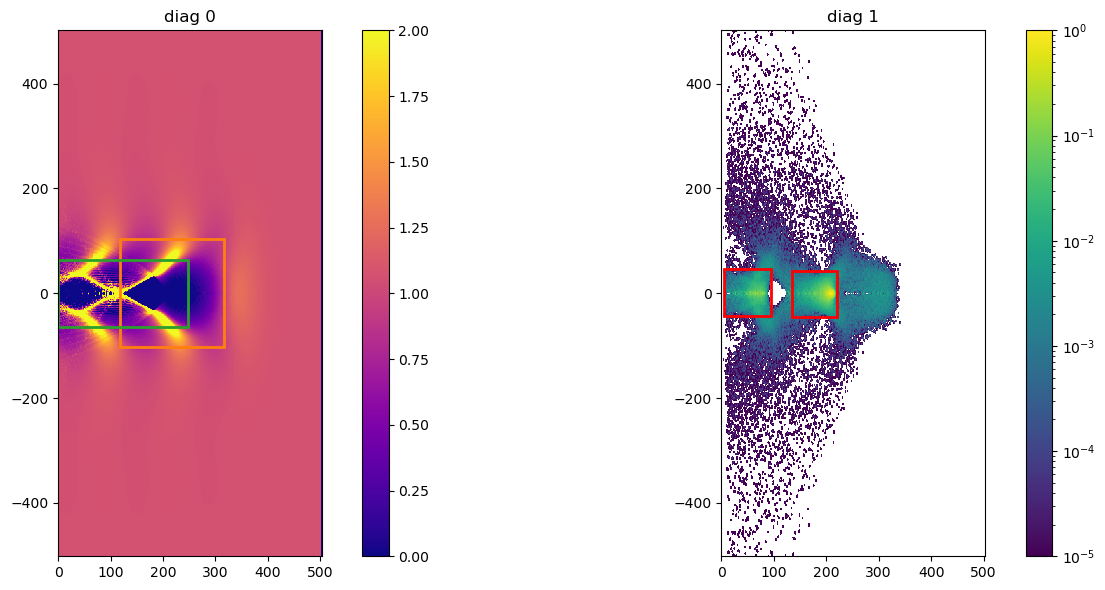

In [69]:
plot_2channel_image(X_test[0:20], y_test[0:20], 12)

Then we plot the predictions

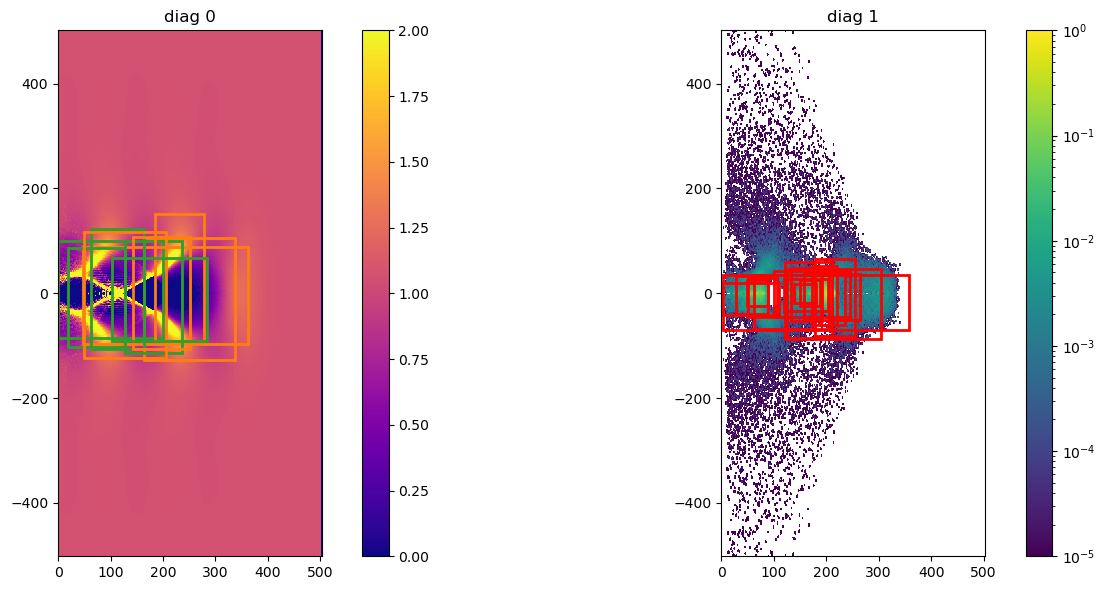

In [70]:
# plot predictions
plot_2channel_image(X_test[0:20], predictions, 12)

In [71]:
from ramp_custom.geometry import apply_NMS_to_predictions

In [73]:
NMS_IOU = 0.1
filtered_predictions = apply_NMS_to_predictions(predictions, iou_threshold=NMS_IOU)
print(len(filtered_predictions[12]))
print(filtered_predictions[12])

5
[{'bbox': [0.4986507296562195, 0.4895570224389098, 0.3439510583877563, 0.2330680216165414], 'class': 1, 'proba': 0.9661169648170471}, {'bbox': [0.3212409257888794, 0.4966530859619752, 0.1686558246612549, 0.06243544652647243], 'class': 0, 'proba': 0.9488866925239563}, {'bbox': [0.11609684526920319, 0.4967221520598371, 0.12329475283622743, 0.07081875526217896], 'class': 0, 'proba': 0.4731602072715759}, {'bbox': [0.4240579605102539, 0.48914270233689694, 0.09118089675903318, 0.09949250567825813], 'class': 0, 'proba': 0.21423164010047913}, {'bbox': [0.19937474727630616, 0.507038929109884, 0.3987494945526123, 0.18559888490758147], 'class': 2, 'proba': 0.8445090651512146}]


We plot the filtered predictions

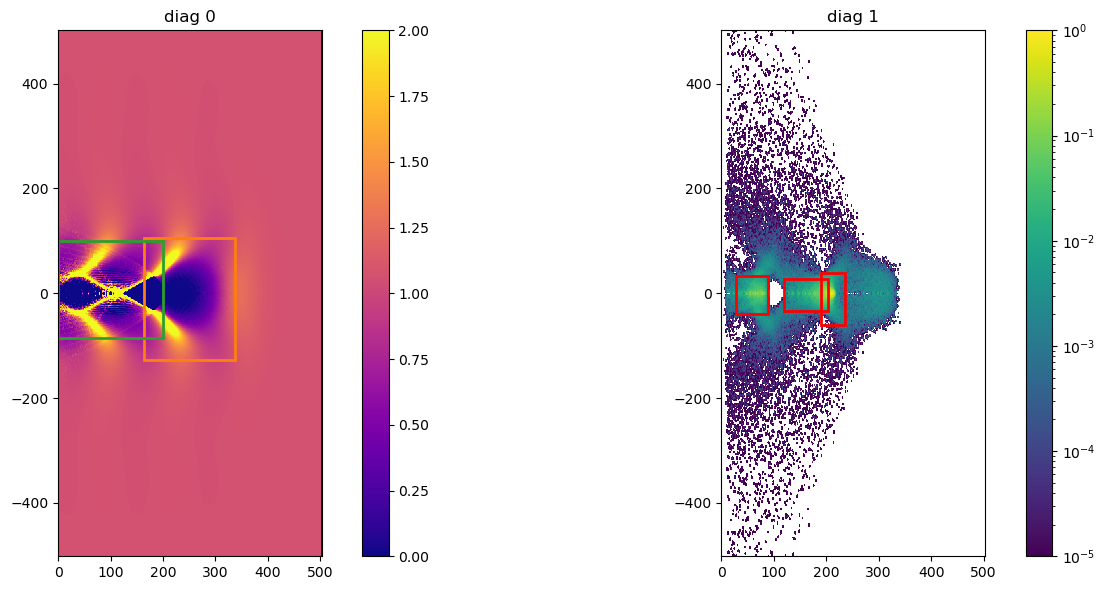

In [74]:
plot_2channel_image(X_test[0:20], filtered_predictions, 12)

Let's compute the AP per class

In [75]:
# Convert predictions to numpy array
predictions = np.array(predictions, dtype=object)

from ramp_custom.scoring import MeanAveragePrecision, ClassAveragePrecision

iou_threshold = problem.SCORING_IOU

# AP for each class
ap_0 = ClassAveragePrecision(class_name='beam_from_ionisation', iou_threshold=iou_threshold)
ap_1 = ClassAveragePrecision(class_name='laser_driven_wakefield', iou_threshold=iou_threshold)
ap_2 = ClassAveragePrecision(class_name='beam_driven_wakefield', iou_threshold=iou_threshold)
ap_3 = ClassAveragePrecision(class_name='beam_from_background', iou_threshold=iou_threshold)

print("AP beam_from_ionisation:", ap_0(y_test[0:20], predictions))
print("AP laser_driven_wakefield:", ap_1(y_test[0:20], predictions))
print("AP beam_driven_wakefield:", ap_2(y_test[0:20], predictions))
print("AP beam_from_background:", ap_3(y_test[0:20], predictions))

AP beam_from_ionisation: 0.3459966269896212
AP laser_driven_wakefield: 0.8593628593628595
AP beam_driven_wakefield: 0.83841642228739
AP beam_from_background: 0.0


And then the AP for the filtered predictions

In [76]:
filtered_predictions = np.array(filtered_predictions, dtype=object)

# AP for each class
ap_0 = ClassAveragePrecision(class_name='beam_from_ionisation', iou_threshold=iou_threshold)
ap_1 = ClassAveragePrecision(class_name='laser_driven_wakefield', iou_threshold=iou_threshold)
ap_2 = ClassAveragePrecision(class_name='beam_driven_wakefield', iou_threshold=iou_threshold)
ap_3 = ClassAveragePrecision(class_name='beam_from_background', iou_threshold=iou_threshold)

print("AP beam_from_ionisation:", ap_0(y_test[0:20], filtered_predictions))
print("AP laser_driven_wakefield:", ap_1(y_test[0:20], filtered_predictions))
print("AP beam_driven_wakefield:", ap_2(y_test[0:20], filtered_predictions))
print("AP beam_from_background:", ap_3(y_test[0:20], filtered_predictions))

AP beam_from_ionisation: 0.47338935574229696
AP laser_driven_wakefield: 0.841880341880342
AP beam_driven_wakefield: 0.9090909090909091
AP beam_from_background: 0.0


Here is the computation of the mean AP for the original and filtered predictions

In [77]:
# Define class names and weights
class_names = ['beam_from_ionisation', 'laser_driven_wakefield', 'beam_driven_wakefield', 'beam_from_background']
weights = [1, 1, 1, 1]  # Equal weights for all classes

# Create mean AP metric
mean_ap = MeanAveragePrecision(class_names=class_names, weights=weights, iou_threshold=iou_threshold)

# Calculate mean AP for original predictions
print("Mean AP (original):", mean_ap(y_test[0:20], predictions))

# Calculate mean AP for filtered predictions 
print("Mean AP (with NMS):", mean_ap(y_test[0:20], filtered_predictions))


Mean AP (original): 0.5109439771599676
Mean AP (with NMS): 0.556090151678387


NMS is integrated in the scoring metric, so you don't need to apply it during inference.

## Submitting to the online challenge: [ramp.studio](https://ramp.studio) <a class="anchor" id="submitting"></a>

Once you found a good model, you can submit it to [ramp.studio](https://www.ramp.studio) to enter the online challenge. First, if it is your first time using the RAMP platform, [sign up](https://www.ramp.studio/sign_up), otherwise [log in](https://www.ramp.studio/login). Then sign up to the event [lwfa](http://www.ramp.studio/events/lwfa_datacamp2024). Both signups are controled by RAMP administrators, so there **can be a delay between asking for signup and being able to submit**.

Once your signup request is accepted, you can go to your [sandbox](https://www.ramp.studio/events/lwfa_datacamp2024/sandbox) and write the code for your classifier directly on the browser. You can also create a new folder `my_submission` in the `submissions` folder containing `object_detector.py` and upload this file directly. You can check the starting-kit ([`object_detector.py`](/edit/submissions/starting_kit/object_detector.py)) for an example. The submission is trained and tested on our backend in the similar way as `ramp-test` does it locally. While your submission is waiting in the queue and being trained, you can find it in the "New submissions (pending training)" table in [my submissions](https://www.ramp.studio/events/lwfa_datacamp2024/my_submissions). Once it is trained, your submission shows up on the [public leaderboard](https://www.ramp.studio/events/lwfa_datacamp2024/leaderboard). 
If there is an error (despite having tested your submission locally with `ramp-test`), it will show up in the "Failed submissions" table in [my submissions](https://www.ramp.studio/events/lwfa_datacamp2024/my_submissions). You can click on the error to see part of the trace.

The data set we use at the backend is usually different from what you find in the starting kit, so the score may be different.

The usual way to work with RAMP is to explore solutions, add feature transformations, select models, etc., _locally_, and checking them with `ramp-test`. The script prints mean cross-validation scores.

The official score in this RAMP (the first score column on the [leaderboard](http://www.ramp.studio/events/lwfa_datacamp2024/leaderboard)) is the mean average precision score (`mean AP`). When the score is good enough, you can submit it at the RAMP.

Here is the script proposed as the starting_kit:

In [78]:
import numpy as np

import torch
from torch import nn
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.transform import GeneralizedRCNNTransform
import torch.optim as optim


class ObjectDetector:
    def __init__(self):
        # Initialize model with pretrained weights
        weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
        self.model = fasterrcnn_resnet50_fpn(weights=weights)

        # Modify the first conv layer to accept 2 channels instead of 3
        # original_conv = self.model.backbone.body.conv1
        self.model.backbone.body.conv1 = nn.Sequential(
            nn.Conv2d(2, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        # Create new transform with 2-channel normalization
        min_size = 640
        max_size = 800  # very close to 798
        image_mean = [0.485, 0.456]
        # Only first 2 channels of original [0.485, 0.456, 0.406]
        image_std = [0.229, 0.224]
        # Only first 2 channels of original [0.229, 0.224, 0.225]
        self.model.transform = GeneralizedRCNNTransform(
            min_size, max_size, image_mean, image_std
        )

        # Replace the classifier with a new one
        # for our number of classes (4 + background)
        num_classes = 5  # 4 classes + background
        in_features = self.model.roi_heads.box_predictor.cls_score.in_features
        self.model.roi_heads.box_predictor = FastRCNNPredictor(
            in_features, num_classes
        )

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)

        self.batch_size = 4

        # Class mapping
        self.int_to_cat = {
            0: "beam_from_ionisation",
            1: "laser_driven_wakefield",
            2: "beam_driven_wakefield", 
            3: "beam_from_background",
        }

    def prepare_data(self, X, y=None, batch_size=4):
        # create dataset class
        class LWFADataset(torch.utils.data.Dataset):
            def __init__(self, X, y=None, device=None):
                self.X = X
                self.y = y
                self.batch_size = batch_size
                self.device = device

            def __len__(self):
                return len(self.X)

            def __getitem__(self, idx):
                # Get and process image
                img = self.X[idx]['data']
                img_tensor = torch.FloatTensor(img).to(self.device)
                if img_tensor.dim() == 2:
                    img_tensor = img_tensor.unsqueeze(0)
                    # Add channel dimension if missing
                img_height = img_tensor.shape[1]
                img_width = img_tensor.shape[2]

                if self.y is not None:
                    # Prepare target dict for training
                    boxes = []
                    labels = []
                    for box in self.y[idx]:
                        # Get box coordinates
                        x_center, y_center, width, height = box['bbox']

                        # Convert from [x_center, y_center, width, height]
                        # to [x1, y1, x2, y2]
                        x1 = (x_center - width/2) * img_width
                        y1 = (y_center - height/2) * img_height
                        x2 = (x_center + width/2) * img_width
                        y2 = (y_center + height/2) * img_height

                        # Add sanity checks
                        if x1 >= 0 and y1 >= 0 and x2 <= img_width and y2 <= img_height:
                            if x2 > x1 and y2 > y1:
                                boxes.append([x1, y1, x2, y2])
                                labels.append(box['class'] + 1)
                                # Add 1 since 0 is background in Faster R-CNN

                    # Create target dict
                    if boxes:
                        target = {
                            'boxes': torch.FloatTensor(boxes).to(self.device),
                            'labels': torch.tensor(
                                labels, dtype=torch.int64
                            ).to(self.device)
                        }
                    else:
                        # If no valid boxes, create empty target
                        target = {
                            'boxes': torch.FloatTensor(size=(0, 4)),
                            'labels': torch.tensor([], dtype=torch.int64)
                        }
                    return img_tensor, target
                return img_tensor

        # Create dataset
        dataset = LWFADataset(X, y, device=self.device)

        # Create data loader
        data_loader = torch.utils.data.DataLoader(
            dataset,
            batch_size=self.batch_size,
            shuffle=True if y is not None else False,
            collate_fn=lambda x: tuple(zip(*x)) if y is not None else torch.stack(x)
        )

        return data_loader

    def fit(self, X, y):
        # Prepare training data
        data_loader = self.prepare_data(X, y, batch_size=4)

        # Set model to training mode
        self.model.train()

        # Create optimizer
        optimizer = optim.SGD(self.model.parameters(),
                              lr=0.01,
                              momentum=0.9,
                              weight_decay=0.0005)
        scheduler = optim.lr_scheduler.ExponentialLR(
            optimizer,
            gamma=0.95  # Reduce lr by 5% each epoch
        )

        # Training loop
        num_epochs = 5
        for epoch in range(num_epochs):
            epoch_loss = 0
            for images, targets in data_loader:
                optimizer.zero_grad()

                # Move input data to the device
                images = [image.to(self.device) for image in images]
                targets = [
                    {k: v.to(self.device) for k, v in t.items()}
                    for t in targets
                ]

                loss_dict = self.model(images, targets)
                losses = sum(loss for loss in loss_dict.values())

                losses.backward()

                # Add gradient clipping
                nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

                optimizer.step()
                epoch_loss += losses.item()
            # Step the scheduler
            scheduler.step()

            # print(f'Epoch {epoch}: Loss = {epoch_loss/len(images)}')

        return self

    def predict(self, X):
        # Set model to evaluation mode
        self.model.eval()

        # Prepare data
        data_loader_test = self.prepare_data(X)

        predictions = []
        with torch.no_grad():
            for batch in data_loader_test:
                # batch shape is [B, C, H, W] where B=4 (batch_size)
                # Process each image in the batch separately
                for single_img in batch:
                    # Add batch dimension back
                    img = single_img.unsqueeze(0)  # [1, C, H, W]
                    pred = self.model(img)[0]
                    img_preds = []
                    print(f"Boxes: {pred['boxes']}")
                    print(f"Labels: {pred['labels']}")
                    print(f"Scores: {pred['scores']}")
                    # Get image dimensions
                    img_height = img[0].shape[1]  # Height is dim 1
                    img_width = img[0].shape[2]   # Width is dim 2
                    for box, label, score in zip(
                        pred['boxes'], pred['labels'], pred['scores']
                    ):
                        if score > 0.25:  # Confidence threshold
                            # Convert box from pixels
                            # to normalized coordinates [0,1]
                            x1, y1, x2, y2 = box.cpu().numpy()
                            # Normalize coordinates
                            x1 = x1 / img_width
                            x2 = x2 / img_width
                            y1 = y1 / img_height
                            y2 = y2 / img_height
                            # Convert from [x1,y1,x2,y2]
                            # to [x_center,y_center,width,height]
                            width = x2 - x1
                            height = y2 - y1
                            x_center = x1 + width/2
                            y_center = y1 + height/2
                            pred_dict = {
                                'bbox': [x_center, y_center, width, height],
                                'class': int(label.cpu().numpy()) - 1,
                                'proba': float(score.cpu().numpy())
                            }
                            img_preds.append(pred_dict)

                    predictions.append(img_preds)

        return np.array(predictions, dtype=object)


You can test your solution locally by running the ramp-test command followed by --submission <my_submission folder>.
Here is an example with the starting_kit submission:

In [29]:
!ramp-test --submission starting_kit --quick-test

Testing Object Detection in Laser Wakefield Acceleration Simulation
Reading train and test files from ./data/ ...
Reading cv ...
Training submissions/starting_kit ...
CV fold 0
	score  mean AP  AP beam_from_ionisation  AP laser_driven_wakefield  AP beam_driven_wakefield  AP beam_from_background       time
	train    0.001                    0.000                        0.0                       0.0                    0.005  68.392295
	valid    0.025                    0.083                        0.0                       0.0                    0.019  31.678353
	test     0.035                    0.000                        0.0                       0.0                    0.139  32.466128
CV fold 1
	score  mean AP  AP beam_from_ionisation  AP laser_driven_wakefield  AP beam_driven_wakefield  AP beam_from_background       time
	train    0.000                      0.0                      0.000                       0.0                      0.0  70.670380
	valid    0.021                  

## More information

See the [online documentation](https://paris-saclay-cds.github.io/ramp-docs/ramp-workflow/stable/using_kits.html) for more details.

## Questions

Questions related to the starting kit should be asked on the [issue tracker](https://github.com/ramp-kits/tephra/issues).